In [1]:
# Upgrade transformers to satisfy kaggle-environments
!pip install --upgrade transformers

# Downgrade torch and install compatible torchvision
!pip install torch==2.0.1 torchvision==0.15.2

# Resolve ydata-profiling conflicts
!pip install scipy==1.10.1
!pip install --upgrade typeguard
# Alternatively, upgrade ydata-profiling
# !pip install --upgrade ydata-profiling

# Install other required packages
!pip install unidecode tensorflow-addons datasets

# Restart the kernel after installations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 67.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.45.1
    Uninstalling transformers-4.45.1:
      Successfully uninstalled transformers-4.45.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 75.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 93.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 70.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Install necessary packages

# Import libraries
import torch
import pandas as pd
import numpy as np
import re
from unidecode import unidecode
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import DistilBertTokenizer, DistilBertModel, Trainer, TrainingArguments, DataCollatorWithPadding, EarlyStoppingCallback
from datasets import Dataset
device = torch.device("cuda") 

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)

PyTorch version: 2.0.1+cu117
CUDA available: True
CUDA version: 11.7


# BERT Model
## 1) Import Necessary Dependencies and use GPU

In [3]:
# Download NLTK stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Define text cleaning functions
def remove_non_alphanum(string):
    if isinstance(string, str):
        string = unidecode(string)
        string = re.sub(r'[^a-zA-Z0-9\s]', '', string)
    return string

def lowercase_and_remove_stopwords(string):
    words = string.lower().split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

# Load the data
train = pd.read_csv('/kaggle/input/movie-plots/train.txt', 
                    delimiter='\t', 
                    names=["Title", "Industry", "Genre", "Director", "Plot"])
test = pd.read_csv('/kaggle/input/movie-plots/test_no_labels.txt', 
                   delimiter='\t', 
                   names=["Title", "Industry", "Director", "Plot"])

# Clean the 'Plot' and 'Director' columns
for df in [train, test]:
    df['Plot'] = df['Plot'].apply(remove_non_alphanum).apply(lowercase_and_remove_stopwords)
    df['Director'] = df['Director'].apply(remove_non_alphanum).apply(lowercase_and_remove_stopwords)


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 3) Check Class Imbalance

In [4]:
# Check for class imbalance
genre_counts = train['Genre'].value_counts()
print("Genre counts in training data:")
print(genre_counts)

Genre counts in training data:
Genre
drama        1676
comedy       1193
horror       1108
action       1059
romance       886
western       829
crime         541
animation     535
sci-fi        214
Name: count, dtype: int64


## 4) Prepare Data

### a. Split Data into Training, Validation and Test Subsets

In [5]:
def split_data(data):
    # Use only the first 100 samples for faster execution
    train_data, tmp_data = train_test_split(
        data, 
        test_size=0.2, 
        shuffle=True,
        random_state=42
    )

    validation_data, test_data = train_test_split(
        tmp_data, 
        test_size=0.5, 
        shuffle=True,
        random_state=42
    )
    return train_data, validation_data, test_data

train_data, val_data, test_data = split_data(train)

### b. Encode Labels and Directors

In [6]:
# Encode genres
label_encoder = LabelEncoder()
train_data['label'] = label_encoder.fit_transform(train_data['Genre'])
val_data['label'] = label_encoder.transform(val_data['Genre'])
test_data['label'] = label_encoder.transform(test_data['Genre'])

## 5) Tokenization

In [7]:
# Initialize tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
tokenizer.add_special_tokens({'additional_special_tokens': ['[DIRECTOR]']})

# Function to tokenize data
def tokenize_function(examples):
    director_names = [f"[DIRECTOR] {director}" for director in examples['Director']]
    texts_with_directors = [f"{director_name} {text}" for director_name, text in zip(director_names, examples['Plot'])]
    return tokenizer(texts_with_directors, padding='max_length', truncation=True, max_length=512)

# Prepare the datasets for Hugging Face
train_dataset = Dataset.from_pandas(train_data[['Plot', 'Director', 'label']])
val_dataset = Dataset.from_pandas(val_data[['Plot', 'Director', 'label']])
test_dataset = Dataset.from_pandas(test_data[['Plot', 'Director', 'label']])

# Apply the tokenization
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set the format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/6432 [00:00<?, ? examples/s]

Map:   0%|          | 0/804 [00:00<?, ? examples/s]

Map:   0%|          | 0/805 [00:00<?, ? examples/s]

## 6) Define the model

In [8]:
import torch.nn as nn

from transformers.modeling_outputs import SequenceClassifierOutput

class DistilBertForGenreClassification(nn.Module):
    def __init__(self, num_labels):
        super(DistilBertForGenreClassification, self).__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.classifier = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(self.bert.config.hidden_size, num_labels)
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask, labels=None):
        # Get BERT output
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_outputs.last_hidden_state[:, 0, :]  # [CLS] token output
        # Get logits from classifier
        logits = self.classifier(pooled_output)
        
        if labels is not None:
            # Compute loss
            loss = self.loss_fn(logits, labels)
            return SequenceClassifierOutput(
                loss=loss,
                logits=logits,
                hidden_states=bert_outputs.hidden_states,
                attentions=bert_outputs.attentions,
            )
        else:
            # Return logits only
            return SequenceClassifierOutput(
                logits=logits,
                hidden_states=bert_outputs.hidden_states,
                attentions=bert_outputs.attentions,
            )


## 7) Instantiate and Train the Model

In [9]:
# Instantiate the model
num_labels = len(label_encoder.classes_)
model = DistilBertForGenreClassification(num_labels=num_labels)
model.bert.resize_token_embeddings(len(tokenizer))
# model = model.to(device)

# Check if the model's parameters are on the GPU
#for param in model.parameters():
    #print(param.device)
    
    
# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    num_train_epochs=10,  # Reduced for faster execution
    # per_device_train_batch_size=4,  # Adjust batch size as needed
    # per_device_eval_batch_size=4,
    weight_decay=0.1,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,
    logging_dir='./logs',
    logging_steps=10,
    report_to=[],
)

# Define compute_metrics function for evaluation
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy = (predictions == labels).mean()
    return {'accuracy': accuracy}

# Data collator
data_collator = DataCollatorWithPadding(tokenizer)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Train the model
trainer.train()


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.883600,0.869172,0.699005
2,0.730600,0.820904,0.720149
3,0.440700,0.997837,0.696517
4,0.206000,1.266589,0.715174


TrainOutput(global_step=3216, training_loss=0.6140826596734832, metrics={'train_runtime': 762.0701, 'train_samples_per_second': 84.402, 'train_steps_per_second': 10.55, 'total_flos': 0.0, 'train_loss': 0.6140826596734832, 'epoch': 4.0})

## 8) Evaluate the Model on the Test Subset

In [10]:
# Evaluate the model's performance on the test data
metrics = trainer.evaluate(test_dataset)
print(metrics)


{'eval_loss': 0.8244450092315674, 'eval_accuracy': 0.7304347826086957, 'eval_runtime': 7.4241, 'eval_samples_per_second': 108.43, 'eval_steps_per_second': 13.604, 'epoch': 4.0}


## 9) Make Predictions on the Test Subset, Calculate Metrics and Plot Confusion Matrix

Classification Report with Accuracy per Genre:

           precision  recall  f1-score  accuracy  support
action        0.6320  0.7670    0.6930    0.7670      103
animation     0.9302  0.7273    0.8163    0.7273       55
comedy        0.6915  0.6019    0.6436    0.6019      108
crime         0.6809  0.6400    0.6598    0.6400       50
drama         0.6409  0.6905    0.6648    0.6905      168
horror        0.8824  0.8750    0.8787    0.8750      120
romance       0.7000  0.4941    0.5793    0.4941       85
sci-fi        0.4643  0.7222    0.5652    0.7222       18
western       0.8889  0.9796    0.9320    0.9796       98


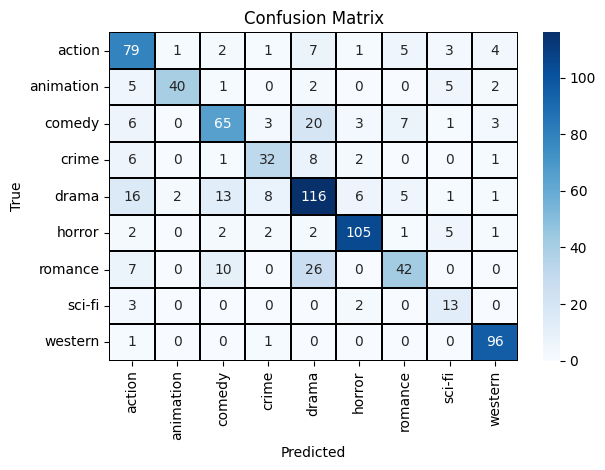

In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Obtain predictions from the model
predictions_output = trainer.predict(test_dataset)
predictions = predictions_output.predictions

# Step 2: Interpret predictions
predicted_class_indices = np.argmax(predictions, axis=1)
predicted_classes = label_encoder.inverse_transform(predicted_class_indices)

# True labels
true_class_indices = test_dataset['label']
true_classes = label_encoder.inverse_transform(true_class_indices)

cm = confusion_matrix(true_classes, predicted_classes, labels=label_encoder.classes_)

def plot_confusion_matrix(y_true, y_pred, cm):
    # Display the confusion matrix
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.1, linecolor='black', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig("BERT_cm")

plot_confusion_matrix(y_true = true_classes, y_pred=predicted_classes, cm=cm)

# Initialize lists to hold metrics
precision_list = []
recall_list = []
f1_score_list = []
support_list = []
accuracy_list = []

total_samples = len(true_classes)

for i, genre in enumerate(label_encoder.classes_):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = total_samples - (TP + FP + FN)
    
    # Calculate metrics
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = TP / (TP + FN) if (TP + FN) > 0 else 0  # Per-genre accuracy as per your definition
    support = TP + FN  # Actual instances of the genre
    
    # Append metrics to lists
    precision_list.append(precision)
    recall_list.append(recall)
    f1_score_list.append(f1)
    accuracy_list.append(accuracy)
    support_list.append(support)

# Create a DataFrame with the metrics
report_df = pd.DataFrame({
    'precision': precision_list,
    'recall': recall_list,
    'f1-score': f1_score_list,
    'accuracy': accuracy_list,
    'support': support_list
}, index=label_encoder.classes_)

# Round the metrics for better readability
report_df = report_df.round(4)

# Print the report
print("Classification Report with Accuracy per Genre:\n")
print(report_df)

## 10) Predict on the Unlabled Test Set

In [13]:
# Prepare the unlabeled test data
unlabeled_test = test.copy()  # Assuming 'test' is your test_no_labels.txt data

# Since we don't have labels, we can use the same process without labels
unlabeled_test_dataset = Dataset.from_pandas(unlabeled_test[['Plot', 'Director']])

# Tokenize the data
unlabeled_test_dataset = unlabeled_test_dataset.map(tokenize_function, batched=True)

# Set the format for PyTorch
unlabeled_test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask'])

# Get predictions
def test_sample_unlabeled(test_dataset, model):
    # Set model to evaluation mode
    model.eval()
    model.to(device)  # Move model to device
    
    # Use DataLoader for batching
    from torch.utils.data import DataLoader
    test_dataloader = DataLoader(test_dataset, batch_size=4)
    
    predictions = []
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)        # Move input_ids to device
            attention_mask = batch['attention_mask'].to(device)  # Move attention_mask to device
            
            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs['logits']
            preds = torch.softmax(logits, dim=1)
            
            # Move predictions to CPU and convert to numpy
            predictions.extend(preds.cpu().numpy())
    return np.array(predictions)


unlabeled_predictions = test_sample_unlabeled(unlabeled_test_dataset, model)

# Decode predictions to labels
unlabeled_predicted_class_indices = np.argmax(unlabeled_predictions, axis=1)
unlabeled_predicted_classes = label_encoder.inverse_transform(unlabeled_predicted_class_indices)


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

## 11) Save the Results of the FInal Predictions

In [14]:
# Write predictions to a text file
with open('results.txt', 'w') as f:
    for idx, pred_label in enumerate(unlabeled_predicted_classes):
        if idx < len(unlabeled_predicted_classes) - 1:
            f.write(f"{pred_label}\n")  # Add newline for all but the last element
        else:
            f.write(f"{pred_label}")  # Write last element without newline

## 12. Testing with bait plots

In [15]:
# === Custom Testing with "Bait" Data ===

# 1. Create Custom Plots with Misleading Keywords
custom_plots = [
    {
        'Title': 'Laughing Shadows',
        'Director': 'John Doe',
        'Plot': "In a quiet town, a group of friends gathers for a fun night of laughter and games, but things take a terrifying turn when they discover a haunted board game that unleashes a hilarious yet deadly ghost."
    },
    {
        'Title': 'Funny Hauntings',
        'Director': 'Jane Smith',
        'Plot': "A family moves into a new house, hoping for a fresh start filled with joy and laughter. Strange, funny noises in the night lead them to a creepy basement where they encounter laughing dolls that bring their worst nightmares to life."
    },
    {
        'Title': 'Jokes of the Dead',
        'Director': 'Mike Johnson',
        'Plot': "An aspiring comedian visits an abandoned comedy club rumored to be haunted. Amidst the echoes of past laughs, he finds a joke book that brings him fame but at a horrifying cost."
    },
    {
        'Title': 'The Hilarious Curse',
        'Director': 'Emily Davis',
        'Plot': "During a comedy festival, a mysterious performer captivates audiences with dark humor that causes uncontrollable laughter, leading to bizarre and deadly consequences."
    },
    {
        'Title': 'Pranks Gone Wrong',
        'Director': 'Robert Brown',
        'Plot': "A group of teenagers decides to spend a funny weekend at a remote cabin. Their jokes and pranks awaken an ancient evil that twists their laughter into screams."
    }
]

# 2. Preprocess and Tokenize the Custom Plots
custom_data = pd.DataFrame(custom_plots)

# Clean the 'Plot' and 'Director' columns
custom_data['Plot'] = custom_data['Plot'].apply(remove_non_alphanum).apply(lowercase_and_remove_stopwords)
custom_data['Director'] = custom_data['Director'].apply(remove_non_alphanum).apply(lowercase_and_remove_stopwords)

# 3. Convert to Dataset and Set Format
custom_dataset = Dataset.from_pandas(custom_data[['Plot', 'Director']])

# Tokenize the data
custom_dataset = custom_dataset.map(tokenize_function, batched=True)

# Set the format for PyTorch
custom_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask'])

# 4. Run Predictions on Custom Plots
# Ensure the model is on the correct device
model.to(device)

# Use the trainer's predict method
custom_predictions_output = trainer.predict(custom_dataset)
custom_predictions = custom_predictions_output.predictions

# Interpret predictions
custom_predicted_class_indices = np.argmax(custom_predictions, axis=1)
custom_predicted_genres = label_encoder.inverse_transform(custom_predicted_class_indices)

# Display the results
print("\n=== Custom Plot Predictions ===\n")
for idx, row in custom_data.iterrows():
    plot = row['Plot']
    title = row['Title']
    original_plot = custom_plots[idx]['Plot']  # Original plot before preprocessing
    predicted_genre = custom_predicted_genres[idx]
    print(f"Title: {title}")
    print("Plot:")
    print(original_plot)
    print(f"Predicted Genre: {predicted_genre}")
    print("-" * 80)


Map:   0%|          | 0/5 [00:00<?, ? examples/s]


=== Custom Plot Predictions ===

Title: Laughing Shadows
Plot:
In a quiet town, a group of friends gathers for a fun night of laughter and games, but things take a terrifying turn when they discover a haunted board game that unleashes a hilarious yet deadly ghost.
Predicted Genre: horror
--------------------------------------------------------------------------------
Title: Funny Hauntings
Plot:
A family moves into a new house, hoping for a fresh start filled with joy and laughter. Strange, funny noises in the night lead them to a creepy basement where they encounter laughing dolls that bring their worst nightmares to life.
Predicted Genre: horror
--------------------------------------------------------------------------------
Title: Jokes of the Dead
Plot:
An aspiring comedian visits an abandoned comedy club rumored to be haunted. Amidst the echoes of past laughs, he finds a joke book that brings him fame but at a horrifying cost.
Predicted Genre: comedy
-----------------------------

## 13. Analysis of poor romance's classification performance

Total 'romance' instances: 85
Misclassified 'romance' instances: 43

Genres predicted instead of 'romance':
drama: 26
comedy: 10
action: 7

Examples of misclassified 'romance' movies:
Title: Romance
Director: clarence brown
Plot: new years eve harry elliott nugent tells grandfather gavin gordon bishop intends marry actress even though frowned upon social class however grandfather recounts via flashback cautionary tale great love affair fallen women youth 28 years old tom armstrong son aristocratic family rector st giles meets famous italian opera star rita cavallini greta garbo evening party given cornelius van tuyl lewis stone tom falls love rita even though rumors van tuyls mistress toms family disapproves rita continues pursue discovers lying true nature relationship van tuyl though forgives loves different lives different social class make engagement untenable ultimately old bishop later married harrys grandmother counsels harry marry woman loves regardless consequences
True Genre:

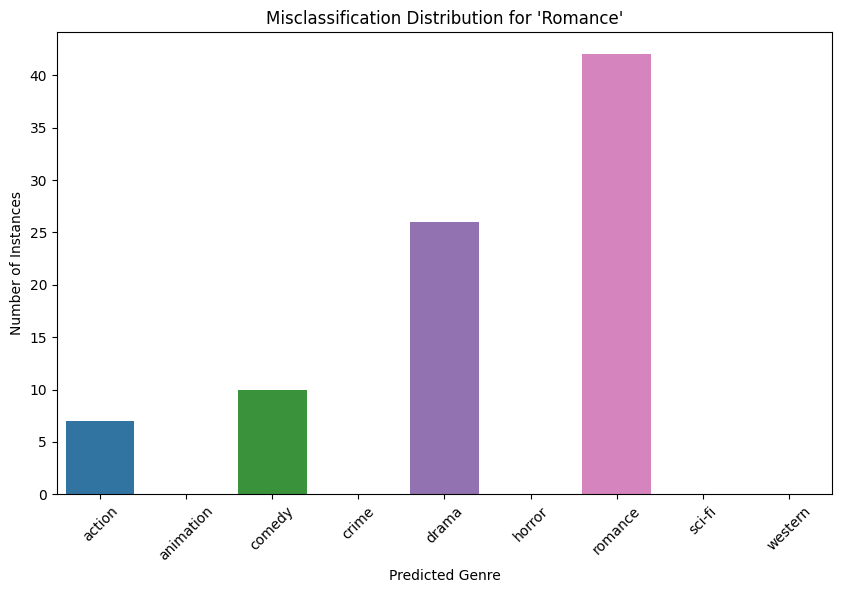

In [16]:
# === Analysis of Misclassified 'Romance' Instances ===

# Step 1: Extract Misclassified Instances for 'Romance'
# Get indices where true genre is 'romance'
romance_indices = np.where(true_classes == 'romance')[0]

# Among these, find indices where the prediction is not 'romance'
misclassified_indices = romance_indices[predicted_classes[romance_indices] != 'romance']

print(f"Total 'romance' instances: {len(romance_indices)}")
print(f"Misclassified 'romance' instances: {len(misclassified_indices)}")

# Step 2: Analyze the Distribution of Predicted Genres
# Get the predicted genres for the misclassified 'romance' instances
misclassified_predicted_genres = predicted_classes[misclassified_indices]

# Count the occurrences of each predicted genre
from collections import Counter

genre_counts = Counter(misclassified_predicted_genres)

print("\nGenres predicted instead of 'romance':")
for genre, count in genre_counts.items():
    print(f"{genre}: {count}")

# Step 3: Display Misclassified Examples
# Get the misclassified examples from the test dataset
# Note: Ensure that 'test_data' is accessible here; if not, you may need to adjust the code
misclassified_data = test_data.reset_index(drop=True).iloc[misclassified_indices]

# Add the predicted genres to the DataFrame
misclassified_data = misclassified_data.copy()
misclassified_data['Predicted_Genre'] = predicted_classes[misclassified_indices]

# Display a few examples
print("\nExamples of misclassified 'romance' movies:")
for idx, row in misclassified_data.head(5).iterrows():
    print(f"Title: {row['Title']}")
    print(f"Director: {row['Director']}")
    print(f"Plot: {row['Plot']}")
    print(f"True Genre: {row['Genre']}")
    print(f"Predicted Genre: {row['Predicted_Genre']}")
    print("-" * 80)

# Step 4: Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Create a subset confusion matrix for 'romance'
romance_row_index = list(label_encoder.classes_).index('romance')
cm_romance = cm[romance_row_index, :]

# Plot the misclassification distribution for 'romance'
plt.figure(figsize=(10, 6))
sns.barplot(x=label_encoder.classes_, y=cm_romance)
plt.title("Misclassification Distribution for 'Romance'")
plt.xlabel("Predicted Genre")
plt.ylabel("Number of Instances")
plt.xticks(rotation=45)
plt.savefig('/kaggle/working/misclassification_distribution_romance.png')
plt.show()
